In [299]:
import pandas as pd
import numpy as np
from random import shuffle
import random
import matplotlib.pyplot as plt
#import seaborn as sns
#from wordcloud import WordCloud, STOPWORDS 
import re
import os
from tqdm.notebook import tqdm
from collections import Counter
import warnings
import nltk
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import pickle

In [300]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

In [301]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [302]:
#!pip install nltk==3.8.1 > /dev/null

In [303]:
file_name = 'data/train.csv'
df = pd.read_csv(file_name)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Class imbalance

In [305]:
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

There is a class imbalance. Let's oversample the disaster class.

In [306]:
add_pos = 4342 - 3271

In [307]:
pos_df = df[df["target"] == 1]

In [308]:
neg_df = df[df["target"] == 0]

In [309]:
pos_df.reset_index(inplace=True)

In [310]:
pos_add_indices = np.random.choice(pos_df.index, add_pos, replace=False)

In [311]:
pos_add_df = pos_df.iloc[pos_add_indices]

In [312]:
pos_oversampled = pd.concat([pos_df, pos_add_df], ignore_index=True)

In [313]:
balanced_df = pd.concat([neg_df, pos_oversampled], ignore_index=True)

In [314]:
balanced_df['target'].value_counts()

target
0    4342
1    4342
Name: count, dtype: int64

### Data preprocessing

In [315]:
balanced_df.fillna('NA', inplace=True)

In [316]:
# Concatenate keyword, location, and text and name the new column as tweet
# Rather than just using the text for prediction, we include keywords and locations just in case they might help.

In [317]:
balanced_df['tweet'] = balanced_df['keyword'] + ' ' + balanced_df['location'] + ' ' + balanced_df['text']

In [318]:
balanced_df.head()

,id,keyword,location,text,target,index,tweet
0,23,NA,NA,What's up man?,0,NA,NA NA What's up man?
1,24,NA,NA,I love fruits,0,NA,NA NA I love fruits
2,25,NA,NA,Summer is lovely,0,NA,NA NA Summer is lovely
3,26,NA,NA,My car is so fast,0,NA,NA NA My car is so fast
4,28,NA,NA,What a goooooooaaaaaal!!!!!!,0,NA,NA NA What a goooooooaaaaaal!!!!!!


In [319]:
len(balanced_df)

8684

In [320]:
# splitting data; train 60%, valid 20%, and test 20%

In [321]:
X = balanced_df['tweet'].values
y = balanced_df['target'].values
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.20, random_state=38)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.25, random_state=28)

In [322]:
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')

train data shape: (5210,)
test data shape: (1737,)


In [323]:
def tokenize_tweets(tweets):
    tokenized_tweets = []
    for tweet in tweets:
        tweet = re.sub(r'[,!?;-]', '.', tweet) #  Punctuations are replaced by "."
        #tweet_lowered = tweet.lower()
        tokenized_tweet = nltk.word_tokenize(tweet) 
        #  Lower case and drop non-alphabetical tokens
        tokenized_tweet = [ch.lower() for ch in tokenized_tweet if ch.isalpha() or ch == '.']  
        tokenized_tweets.append(tokenized_tweet)
    return tokenized_tweets

In [324]:
def stopwords_tweets(tokenized_tweets):
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords_tweets = []
    for tokenized_tweet in tokenized_tweets:
        tokens_wo_stopwords = [t for t in tokenized_tweet if t not in english_stopwords] 
        tokens_wo_stopwords_tweets.append(tokens_wo_stopwords) 
    return tokens_wo_stopwords_tweets

### Create word corpus using X_train

In [325]:
tokenized_tweets_train = tokenize_tweets(X_train)

In [326]:
tokenized_tweets_train_wo_stopwords = stopwords_tweets(tokenized_tweets_train)

In [327]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [328]:
word_list = flatten(tokenized_tweets_train_wo_stopwords)

In [329]:
vocab_count = Counter(word_list)

In [330]:
type(vocab_count)

collections.Counter

**Let's use 1000 most popular words for the initial analysis**

In [331]:
vocab =  sorted(vocab_count,key=vocab_count.get,reverse=True)[:1000]

In [332]:
vocab_dict = {w:i+1 for i,w in enumerate(vocab)}

### Tweet length statistics in train, valid, and test sets

In [333]:
tokenized_tweets_valid = tokenize_tweets(X_valid)
tokenized_tweets_valid_wo_stopwords = stopwords_tweets(tokenized_tweets_valid)

In [334]:
tokenized_tweets_test = tokenize_tweets(X_test)
tokenized_tweets_test_wo_stopwords = stopwords_tweets(tokenized_tweets_test)

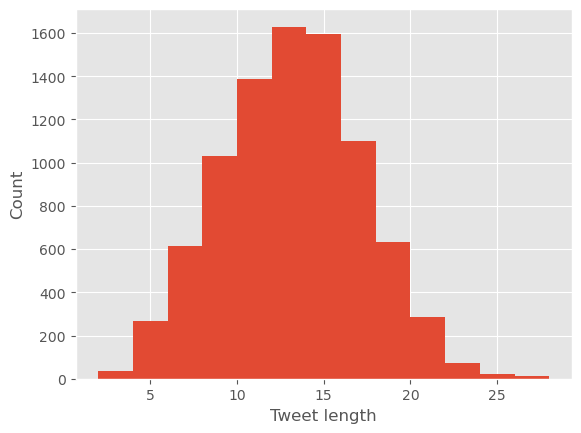

In [335]:
# Tweet lengths (train, valid, and test data combined)
plt.hist([len(t) for t in tokenized_tweets_train_wo_stopwords + tokenized_tweets_valid_wo_stopwords + 
          tokenized_tweets_test_wo_stopwords], bins=13);
plt.ylabel('Count')
plt.xlabel('Tweet length');

In [336]:
# maximum length of tweets 
max_len = max(len(w) for w in tokenized_tweets_train_wo_stopwords + tokenized_tweets_valid_wo_stopwords + tokenized_tweets_test_wo_stopwords)
max_len

28

In [337]:
# Using this max_len, let's build padded vectors

In [338]:
# Here the argument tweet is a tokenized tweet without stop words.
def padded_vector(tweet, vocab_dict, max_len):
    int_tweet = []
    for word in tweet:
        if word in vocab_dict:
            int_tweet.append(vocab_dict[word])  

    padded_vector = int_tweet + [0] * max(0, max_len - len(int_tweet))
    return padded_vector

In [339]:
# Here tweet in the argument is a tokenized tweet without stop words.
def padded_vector(tweet, vocab_dict, max_len):
    int_tweet = []
    if len(tweet) <= max_len:
        for word in tweet:
            if word in vocab_dict:
                int_tweet.append(vocab_dict[word])  
    else:  # tweet is longer than maximum length 
        for word in tweet[:max_len]:  # truncate the tweet
            if word in vocab_dict:
                int_tweet.append(vocab_dict[word])             
    padded_vector = int_tweet + [0] * max(0, max_len - len(int_tweet))
    return padded_vector

In [340]:
x_train_padded = [padded_vector(x, vocab_dict, max_len) for x in tokenized_tweets_train_wo_stopwords]
x_valid_padded = [padded_vector(x, vocab_dict, max_len) for x in tokenized_tweets_valid_wo_stopwords]

In [341]:
print(f" The length of train padded: {len(x_train_padded)}")
print(f" The length of valid padded: {len(x_valid_padded)}")

 The length of train padded: 5210
 The length of valid padded: 1737


### Create final dataset for training

In [342]:
batch_size = 50

In [343]:
x_train_padded = np.array(x_train_padded)
x_valid_padded = np.array(x_valid_padded)

In [344]:
# Create tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_padded), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_valid_padded), torch.from_numpy(y_valid))

In [345]:
# Set up dataloader with shuffle on
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [346]:
# Display tweet and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([50, 28])
Labels batch shape: torch.Size([50])


In [347]:
tweet_0 = train_features[0].squeeze()
label_0 = train_labels[0]
print(f"Tweet: {tweet_0}\nLabel: {label_0}")

Tweet: tensor([3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Label: 1
